In [47]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
from operator import itemgetter

import re
import json

import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

In [48]:
import tweepy
from tweepy.auth import OAuthHandler
API_KEY="1jFG5MF4PNf8zhg8Nmkk3kWVb"
API_SECRET="MOfU9zxDvsk7nKHLnYvpTUeWW5C7PsXrS9TuwnvYcx3ANzc5LG"
ACCESS_TOKEN= "2343077714-N9yB6UKYegygTgTPl7xgm7PfUbLhO6TzqitlFP0"
ACCESS_TOKEN_SECRET="d44DHDHV3CYmeuDnWbITumnPcnrVJwS0mJhgITQYWyXdx"
auth = OAuthHandler(API_KEY, API_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

Yuting


In [49]:
import time
st = time.time()
import tweepy
import jsonpickle
import csv
tweetsPerQuery = 5000
max_tweets = 100000000

fName = 'hyperloop_tweets.txt' 


since_id = None
max_id = -1
tweet_count = 0


search_query="#hyperloop"
x=0
with open(fName,'w') as f:
    print("Downloading hashtag" + search_query)
    while(tweet_count<max_tweets):
        try:
            if(max_id<=0):
                if(not since_id):
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended')

                else:
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended',since_id=since_id)
            else:
                if(not since_id):
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended',max_id=str(max_id-1))
                else:
                    new_tweets = api.search(q=search_query,count=tweetsPerQuery,lang="en",tweet_mode='extended',max_id=str(max_id-1),since_id=since_id)

            # Tweets Exhausted
            if(not new_tweets):
                print("No more tweets found!!")
                break
            # write all the new_tweets to a json file
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json,unpicklable=False)+'\n')
                tweet_count+=len(new_tweets)
                print("Successfully downloaded {0} tweets".format(tweet_count))
                max_id=new_tweets[-1].id
        # in case of any error
        except tweepy.TweepError as e:
                print("Some error!!:"+str(e))
                break
end = time.time()

print("A total of {0} tweets are downloaded and saved to {1}".format(tweet_count,fName))
print("Total time taken is ",end-st,"seconds.")

Successfully downloaded 100 tweets
Successfully downloaded 200 tweets
Successfully downloaded 300 tweets
Successfully downloaded 400 tweets
Successfully downloaded 500 tweets
Successfully downloaded 600 tweets
Successfully downloaded 700 tweets
Successfully downloaded 800 tweets
Successfully downloaded 900 tweets
Successfully downloaded 1000 tweets
Successfully downloaded 1100 tweets
Successfully downloaded 1200 tweets
Successfully downloaded 1300 tweets
Successfully downloaded 1400 tweets
Successfully downloaded 1500 tweets
Successfully downloaded 1600 tweets
Successfully downloaded 1700 tweets
Successfully downloaded 1800 tweets
Successfully downloaded 1900 tweets
Successfully downloaded 2000 tweets
Successfully downloaded 2100 tweets
Successfully downloaded 2200 tweets
Successfully downloaded 2300 tweets
Successfully downloaded 2400 tweets
Successfully downloaded 2500 tweets
Successfully downloaded 2600 tweets
Successfully downloaded 2700 tweets
Successfully downloaded 2800 tweets
S

Successfully downloaded 30100 tweets
Successfully downloaded 30200 tweets
Successfully downloaded 30300 tweets
Successfully downloaded 30400 tweets
Successfully downloaded 30500 tweets
Successfully downloaded 30600 tweets
Successfully downloaded 30700 tweets
Successfully downloaded 30800 tweets
Successfully downloaded 30900 tweets
Successfully downloaded 31000 tweets
Successfully downloaded 31100 tweets
Successfully downloaded 31200 tweets
Successfully downloaded 31300 tweets
Successfully downloaded 31400 tweets
Successfully downloaded 31500 tweets
Successfully downloaded 31600 tweets
Successfully downloaded 31700 tweets
Successfully downloaded 31800 tweets
Successfully downloaded 31900 tweets
Successfully downloaded 32000 tweets
Successfully downloaded 32100 tweets
Successfully downloaded 32200 tweets
Successfully downloaded 32300 tweets
Successfully downloaded 32400 tweets
Successfully downloaded 32500 tweets
Successfully downloaded 32600 tweets
Successfully downloaded 32700 tweets
S

In [50]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [51]:
# Read json into a pandas dataframe
tweets_df = pd.read_json("hyperloop_tweets.txt", lines=True)

In [52]:
tweets_df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'metadata', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'retweet_count',
       'retweeted', 'retweeted_status', 'source', 'truncated', 'user'],
      dtype='object')

In [53]:
tweets_final = pd.DataFrame(columns = ["created_at", "id", "in_reply_to_screen_name", "in_reply_to_status_id", "in_reply_to_user_id",
                                      "retweeted_id", "retweeted_screen_name", "user_mentions_screen_name", "user_mentions_id", 
                                       "text", "user_id", "screen_name", "followers_count"])

In [54]:
# Columns that are going to be the same
equal_columns = ["created_at", "id", "full_text"]
tweets_final[equal_columns] = tweets_df[equal_columns]

In [55]:
def get_basics(tweets_final):
    tweets_final["screen_name"] = tweets_df["user"].apply(lambda x: x["screen_name"])
    tweets_final["user_id"] = tweets_df["user"].apply(lambda x: x["id"])
    tweets_final["followers_count"] = tweets_df["user"].apply(lambda x: x["followers_count"])
    return tweets_final

In [56]:
def get_usermentions(tweets_final):
    # Inside the tag 'entities' will find 'user mentions' and will get 'screen name' and 'id'
    tweets_final["user_mentions_screen_name"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["screen_name"] if x["user_mentions"] else np.nan)
    tweets_final["user_mentions_id"] = tweets_df["entities"].apply(lambda x: x["user_mentions"][0]["id_str"] if x["user_mentions"] else np.nan)
    return tweets_final

In [57]:
def get_retweets(tweets_final):
    # Inside the tag 'retweeted_status' will find 'user' and will get 'screen name' and 'id'    
    tweets_final["retweeted_screen_name"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["screen_name"] if x is not np.nan else np.nan)
    tweets_final["retweeted_id"] = tweets_df["retweeted_status"].apply(lambda x: x["user"]["id_str"] if x is not np.nan else np.nan)
    return tweets_final

In [58]:
def get_in_reply(tweets_final):
    # Just copy the 'in_reply' columns to the new dataframe
    tweets_final["in_reply_to_screen_name"] = tweets_df["in_reply_to_screen_name"]
    tweets_final["in_reply_to_status_id"] = tweets_df["in_reply_to_status_id"]
    tweets_final["in_reply_to_user_id"]= tweets_df["in_reply_to_user_id"]
    return tweets_final

In [59]:
def fill_df(tweets_final):
    get_basics(tweets_final)
    get_usermentions(tweets_final)
    get_retweets(tweets_final)
    get_in_reply(tweets_final)
    return tweets_final

In [60]:

def get_interactions(row):
    user = row["user_id"], row["screen_name"]
    if user[0] is None:
        return (None, None), []

    interactions = set()
    interactions.add((row["in_reply_to_user_id"], row["in_reply_to_screen_name"]))
    interactions.add((row["retweeted_id"], row["retweeted_screen_name"]))
    interactions.add((row["user_mentions_id"], row["user_mentions_screen_name"]))
    interactions.discard((row["user_id"], row["screen_name"]))
    interactions.discard((None, None))
    return user, interactions

In [61]:
tweets_final = fill_df(tweets_final)

In [62]:
tweets_final = tweets_final.where((pd.notnull(tweets_final)), None)

In [63]:
tweets_final.head(5)

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count,full_text
0,2019-12-12 15:49:53,1205152802839900161,None,None,None,None,None,None,None,None,1143596939549663233,JessicaCryptoML,399,Facing disappointing sales of its augmented re...
1,2019-12-12 14:53:59,1205138736956071939,None,None,None,None,None,None,None,None,151023880,nikhilrbohra,338,Nice way to tell the investors that no infra p...
2,2019-12-12 14:30:30,1205132826808586241,None,None,None,None,None,None,None,None,1140999897358962688,NewMobilities,1508,Global infrastructure company proposes hyperlo...
3,2019-12-12 14:24:27,1205131303231934464,None,None,None,162492285,Braddock512,Braddock512,162492285,None,4543515618,htx_17,29,RT @Braddock512: @elonmusk Hopefully we’ll get...
4,2019-12-12 14:24:01,1205131191717965824,None,None,None,719472337,CathyHackl,CathyHackl,719472337,None,757365218,RickKing16,120398,RT @CathyHackl: Proud to work for @MagicLeap &...


In [64]:
import pandas as pd
import re
import time
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag,map_tag
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

pstem = PorterStemmer()
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')

def clean_df(tweets_final):
    
   
    tweets_final=tweets_final.drop_duplicates(['full_text']) 
    tweets_final=tweets_final.reset_index(drop=True)
   
    
    
    # BASIC CLEANING FUNCTION
    for i in range(len(tweets_final)):
        txt = tweets_final.loc[i]["full_text"]
        txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#username-tags
        txt=re.sub(r'^[RT]+','',txt)#RT-tags
        txt = re.sub('https?://[A-Za-z0-9./]+','',txt)#URLs
        txt=re.sub("[^a-zA-Z]", " ",txt)#hashtags
        tweets_final.at[i,"full_text"]=txt
    #POS-TAGGING AND SENTIMENT SCORE
    li_swn=[]
    li_swn_pos=[]
    li_swn_neg=[]
    missing_words=[]
    for i in range(len(tweets_final.index)):
        text = tweets_final.loc[i]['full_text']
        tokens = nltk.word_tokenize(text)
        tagged_sent = pos_tag(tokens)
        store_it = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in tagged_sent]
       

        pos_total=0
        neg_total=0
        for word,tag in store_it:
            if(tag=='NOUN'):
                tag='n'
            elif(tag=='VERB'):
                tag='v'
            elif(tag=='ADJ'):
                tag='a'
            elif(tag=='ADV'):
                tag = 'r'
            else:
                tag='nothing'

            if(tag!='nothing'):   
                concat = word+'.'+tag+'.01'
                try:
                    this_word_pos=swn.senti_synset(concat).pos_score()
                    this_word_neg=swn.senti_synset(concat).neg_score()
                  
                except Exception as e:
                    wor = lem.lemmatize(word)
                    concat = wor+'.'+tag+'.01'
                    # Checking if there's a possiblity of lemmatized word be accepted into SWN corpus
                    try:
                        this_word_pos=swn.senti_synset(concat).pos_score()
                        this_word_neg=swn.senti_synset(concat).neg_score()
                    except Exception as e:
                        wor = pstem.stem(word)
                        concat = wor+'.'+tag+'.01'
                        # Checking if there's a possiblity of lemmatized word be accepted
                        try:
                            this_word_pos=swn.senti_synset(concat).pos_score()
                            this_word_neg=swn.senti_synset(concat).neg_score()
                        except:
                            missing_words.append(word) 
                            continue
                pos_total+=this_word_pos
                neg_total+=this_word_neg
        li_swn_pos.append(pos_total)
        li_swn_neg.append(neg_total)

        if(pos_total!=0 or neg_total!=0):
            if(pos_total>neg_total):
                li_swn.append(1)
            else:
                li_swn.append(-1)
        else:
            li_swn.append(0)
    # end-of pos-tagging&sentiment
    
       
    #LEMMATIZING,STEMMING,STOP-WORDS
    for i in range(len(tweets_final.index)):
        text = tweets_final.loc[i]['full_text']
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]

        for j in range(len(tokens)):
            tokens[j] = lem.lemmatize(tokens[j])
            tokens[j] = pstem.stem(tokens[j])

        tokens_sent=' '.join(tokens)
        tweets_final.at[i,"full_text"] = tokens_sent
        
    tweets_final.insert(14,"pos_score",li_swn_pos,True)
    tweets_final.insert(15,"neg_score",li_swn_neg,True)
    tweets_final.insert(16,"sent_score",li_swn,True)
    
    
    
    return tweets_final

st=time.time()
tweets_final= clean_df(tweets_final)
end=time.time()


print(end-st)



2.2269721031188965


In [65]:
tweets_final.head(5)

,created_at,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,retweeted_id,retweeted_screen_name,user_mentions_screen_name,user_mentions_id,text,user_id,screen_name,followers_count,full_text,pos_score,neg_score,sent_score
0,2019-12-12 15:49:53,1205152802839900161,None,None,None,None,None,None,None,None,1143596939549663233,JessicaCryptoML,399,face disappoint sale augment realiti headset m...,0,1,-1
1,2019-12-12 14:53:59,1205138736956071939,None,None,None,None,None,None,None,None,151023880,nikhilrbohra,338,nice way tell investor infra project india eve...,1,0,1
2,2019-12-12 14:30:30,1205132826808586241,None,None,None,None,None,None,None,None,1140999897358962688,NewMobilities,1508,global infrastructur compani propos hyperloop ...,0,0,-1
3,2019-12-12 14:24:27,1205131303231934464,None,None,None,162492285,Braddock512,Braddock512,162492285,None,4543515618,htx_17,29,hope get fast travel next updat hyperloop,0,0,1
4,2019-12-12 14:24:01,1205131191717965824,None,None,None,719472337,CathyHackl,CathyHackl,719472337,None,757365218,RickKing16,120398,proud work amp help enterpris partner like mcl...,0,0,1


In [21]:
tweets_final.describe()

,id,user_id,followers_count,pos_score,neg_score,sent_score
count,230,230,230,230,230,230
mean,1202913778966368256,364030974672940544,5319,1,0,0
std,976001013900857,487281764662674688,28687,1,0,1
min,1201401306231005184,9019142,0,0,0,-1
25%,1202185155646869504,135728875,109,0,0,-1
50%,1202603423507449856,1278832573,524,0,0,1
75%,1203727614874142720,870963511567998976,1692,1,0,1
max,1204704556883398656,1201079143326203904,380764,3,3,1


In [71]:
graph = nx.Graph()

In [72]:
for index, tweet in tweets_final.iterrows():
    user, interactions = get_interactions(tweet)
    user_id, user_name = user
    tweet_id = tweet["id"]
    tweet_sent = tweet["sent_score"]
    for interaction in interactions:
        int_id, int_name = interaction
        graph.add_edge(user_id, int_id, tweet_id=tweet_id)
        

        graph.node[user_id]["name"] = user_name
        graph.node[int_id]["name"] = int_name

In [73]:
print(f"There are {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges present in the Graph")

There are 293 nodes and 197 edges present in the Graph


In [74]:
degrees = [val for (node, val) in graph.degree()]

In [75]:
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 9
The minimum degree of the Graph is 1


In [76]:
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}")

The average degree of the nodes in the Graph is 1.3
The most frequent degree of the nodes found in the Graph is 1


In [77]:
if nx.is_connected(graph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is not connected


In [78]:
print(f"There are {nx.number_connected_components(graph)} connected components in the Graph")

There are 103 connected components in the Graph


In [79]:
largest_subgraph = max(nx.connected_component_subgraphs(graph), key=len)

In [80]:
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} \
edges present in the largest component of the Graph")

There are 30 nodes and 30 edges present in the largest component of the Graph


In [81]:
if nx.is_connected(largest_subgraph):
    print("The graph is connected")
else:
    print("The graph is not connected")

The graph is connected


In [82]:

print(f"The average clustering coefficient is {nx.average_clustering(largest_subgraph)} in the largest subgraph")
print(f"The transitivity of the largest subgraph is {nx.transitivity(largest_subgraph)}")

The average clustering coefficient is 0.04603174603174603 in the largest subgraph
The transitivity of the largest subgraph is 0.047619047619047616


In [83]:

print(f"The diameter of our Graph is {nx.diameter(largest_subgraph)}")
print(f"The average distance between any two nodes is {nx.average_shortest_path_length(largest_subgraph):.2f}")

The diameter of our Graph is 11
The average distance between any two nodes is 4.69


In [84]:
graph_centrality = nx.degree_centrality(largest_subgraph)

In [85]:
max_de = max(graph_centrality.items(), key=itemgetter(1))

In [86]:
graph_closeness = nx.closeness_centrality(largest_subgraph)

In [87]:
max_clo = max(graph_closeness.items(), key=itemgetter(1))

In [88]:
graph_betweenness = nx.betweenness_centrality(largest_subgraph, normalized=True, endpoints=False)

In [89]:
max_bet = max(graph_betweenness.items(), key=itemgetter(1))

In [90]:
print(f"the node with id {max_de[0]} has a degree centrality of {max_de[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_clo[0]} has a closeness centrality of {max_clo[1]:.2f} which is the maximum of the Graph")
print(f"the node with id {max_bet[0]} has a betweenness centrality of {max_bet[1]:.2f} which is the maximum of the Graph")

the node with id 4837939093 has a degree centrality of 0.24 which is the maximum of the Graph
the node with id 696025468252897281 has a closeness centrality of 0.31 which is the maximum of the Graph
the node with id 829321185594863620 has a betweenness centrality of 0.60 which is the maximum of the Graph


In [94]:
node_and_degree = largest_subgraph.degree()
colors_central_nodes = ['orange', 'red']
central_nodes = ['4837939093', '696025468252897281']

In [95]:
pos = nx.spring_layout(largest_subgraph, k=0.05)

In [96]:
%matplotlib inline

C:\Users\LENOVO\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


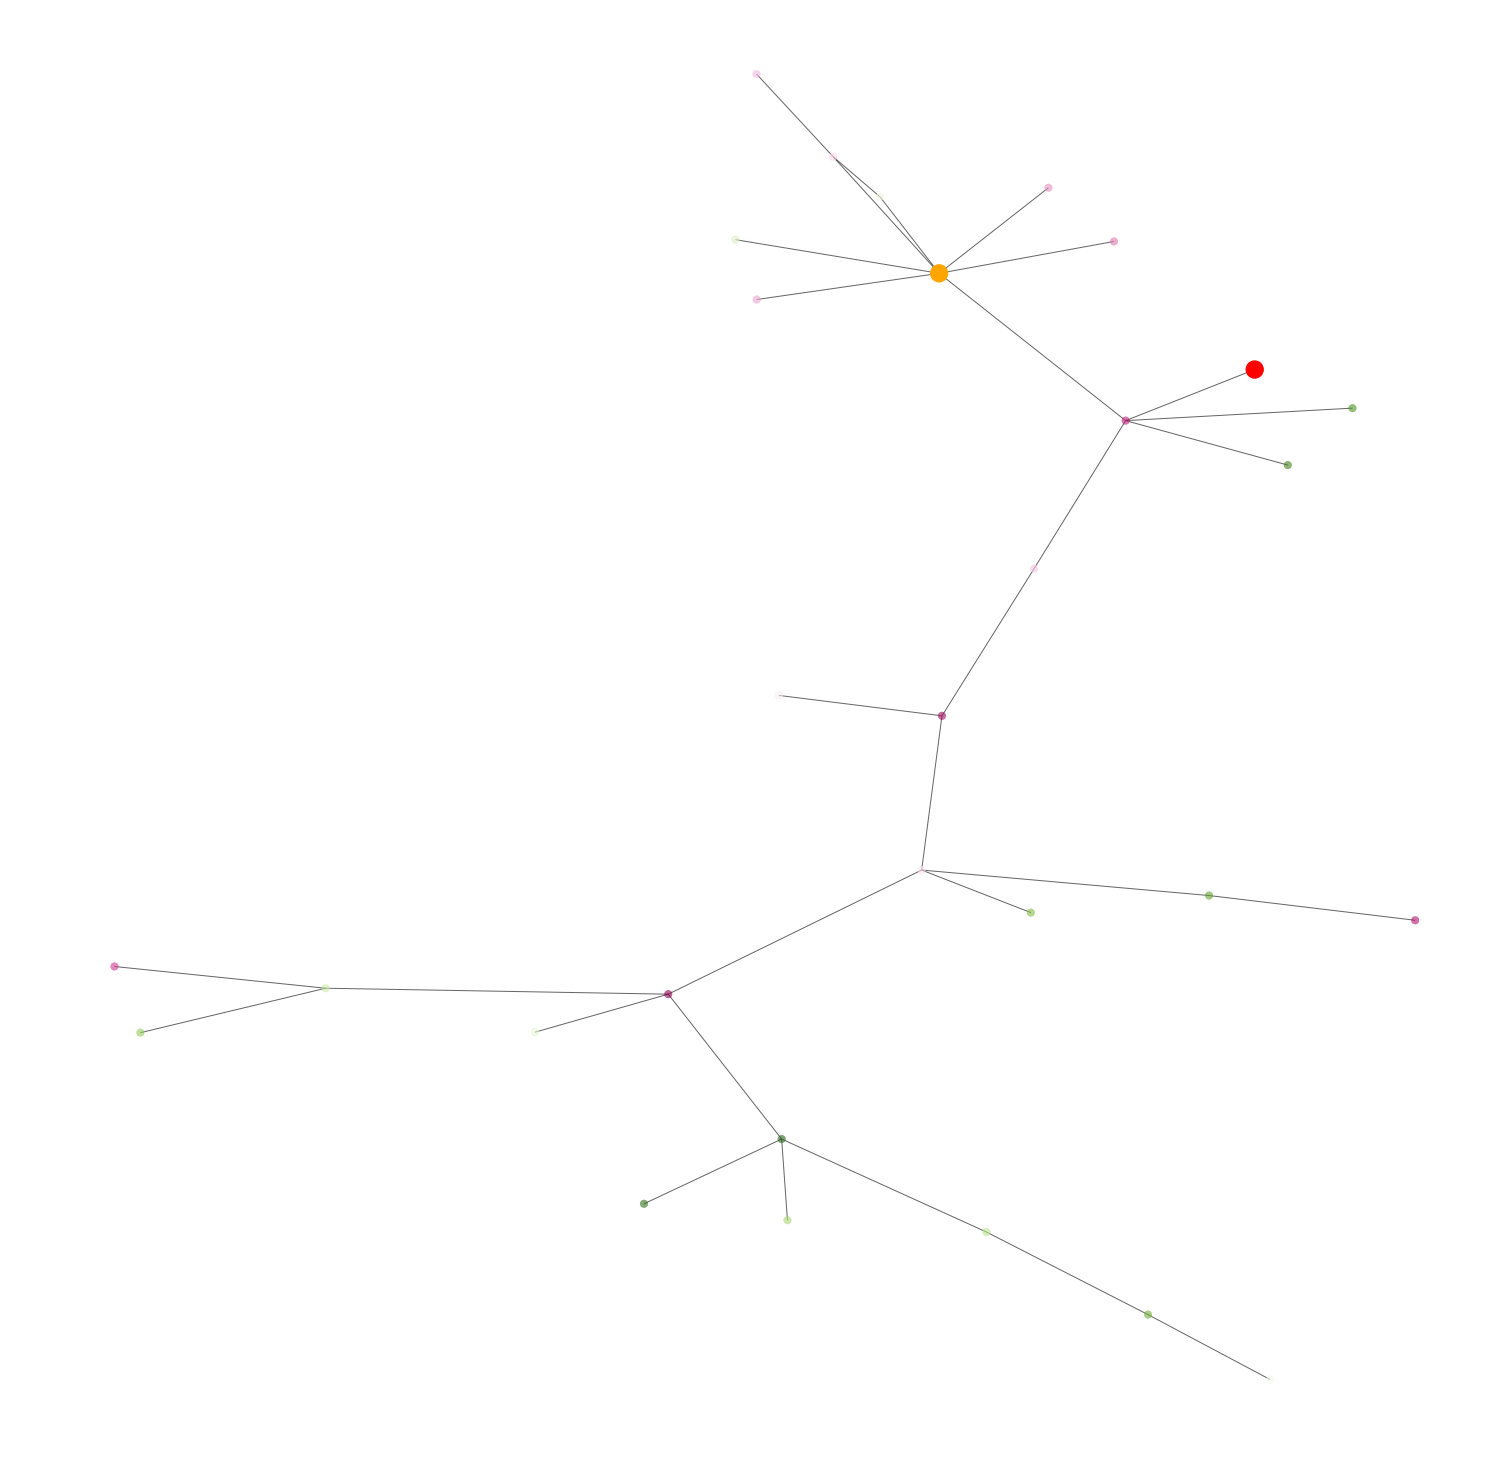

In [97]:
plt.figure(figsize = (20,20))
nx.draw(largest_subgraph, pos=pos, node_color=range(30),cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
nx.draw_networkx_nodes(largest_subgraph, pos=pos, nodelist=central_nodes, node_size=300, node_color=colors_central_nodes)
plt.savefig('graphfinal.png')
plt.show()

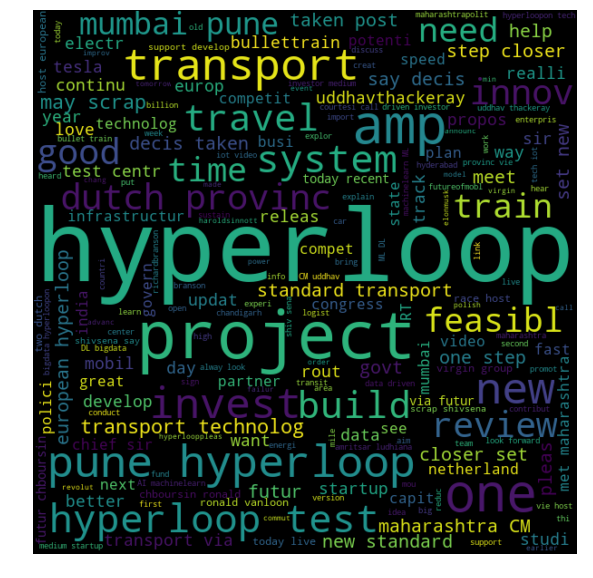

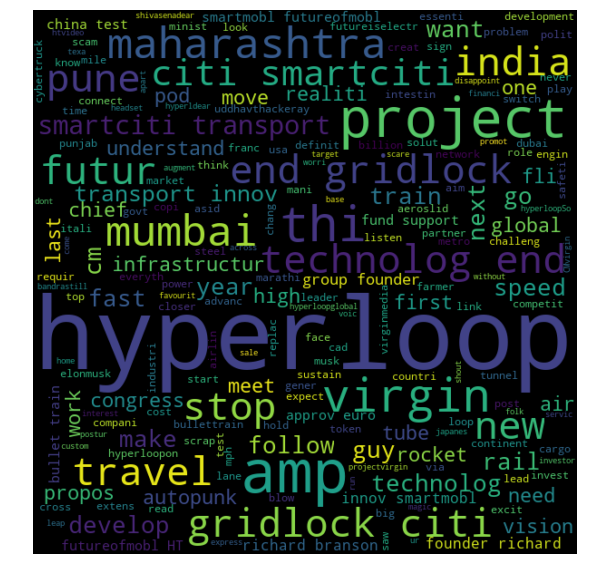

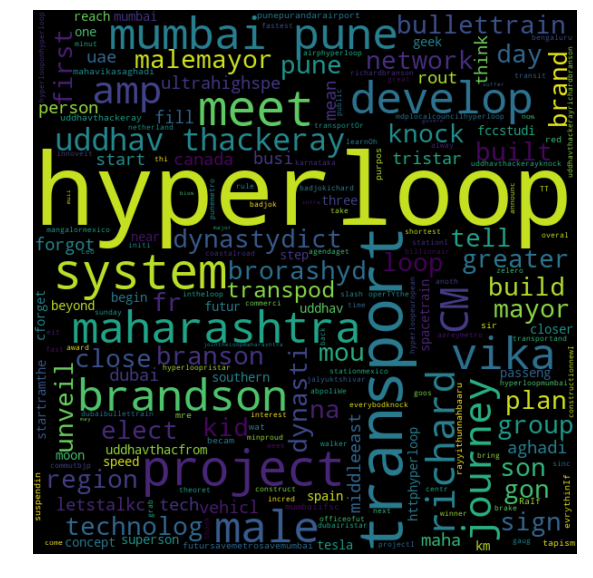

In [66]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# GENERATE POSITIVE TEXT,NEGATIVE TEXT,NEUTRAL TEXT FOR DATA-VISUALISATION
pos_text=""
neg_text=""
neut_text=""

for i in range(len(tweets_final.index)):
    if(tweets_final.loc[i]["sent_score"]==1):
        pos_text+=tweets_final.loc[i]["full_text"]
    elif(tweets_final.loc[i]["sent_score"]==-1):
        neg_text+=tweets_final.loc[i]["full_text"]
    else:
        neut_text+=tweets_final.loc[i]["full_text"]

list_text = [pos_text,neg_text,neut_text]


for txt in list_text:
    word_cloud = WordCloud(width = 600,height = 600,max_font_size = 200).generate(txt)
    plt.figure(figsize=(12,10))# create a new figure
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()



In [67]:
def graph(word_frequency, sent):
    labels = word_frequency[0][1:51].index
    title = "Word Frequency for %s" %sent
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(50), word_frequency[0][1:51], width = 0.8, color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(50), labels, rotation=90, size=14);
    plt.xlabel("50 more frequent words", size=14);
    plt.ylabel("Frequency", size=14);
    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show()

In [68]:
import sklearn
from sklearn.model_selection import train_test_split
SEED=4
x = tweets_final.full_text
y = tweets_final.sent_score
x_train,x_val_test,y_train,y_val_test = train_test_split(x,y,test_size=0.1,random_state=SEED)
x_val,x_test,y_val,y_test = train_test_split(x_val_test,y_val_test,test_size=0.5,random_state=SEED)

In [69]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(decode_error='ignore',lowercase=False,max_features=11)
x_traincv=cv.fit_transform(x_train.values.astype('U'))

[('transport', 48), ('project', 42), ('one', 28), ('new', 27), ('amp', 26), ('pune', 25), ('We', 24), ('mumbai', 24), ('futur', 23), ('technolog', 23)]


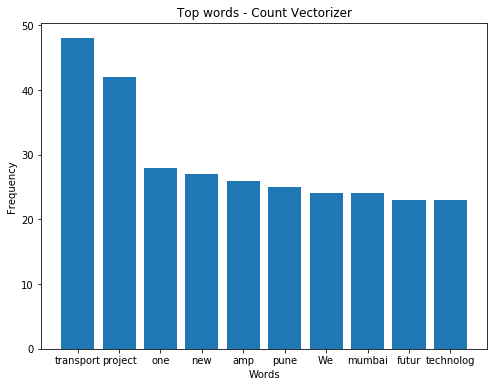

In [70]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(decode_error='ignore',lowercase=False,max_features=11)
x_traincv=cv.fit_transform(x_train.values.astype('U'))
top_sum=x_traincv.toarray().sum(axis=0)
top_sum_cv=[top_sum]#to let pandas know that these are rows
columns_cv = cv.get_feature_names()
x_traincvdf = pd.DataFrame(top_sum_cv,columns=columns_cv)


import operator
dic = {}
for i in range(len(top_sum_cv[0])):
    dic[columns_cv[i]]=top_sum_cv[0][i]
sorted_dic=sorted(dic.items(),reverse=True,key=operator.itemgetter(1))
print(sorted_dic[1:])
bins = [w for w,v in sorted_dic][1:]
freq = [v for w,v in sorted_dic][1:]
from matplotlib import pyplot as plt

plt.figure(figsize=(8,6))
plt.bar(bins,freq)
plt.xlabel('Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top words - Count Vectorizer')
plt.show()

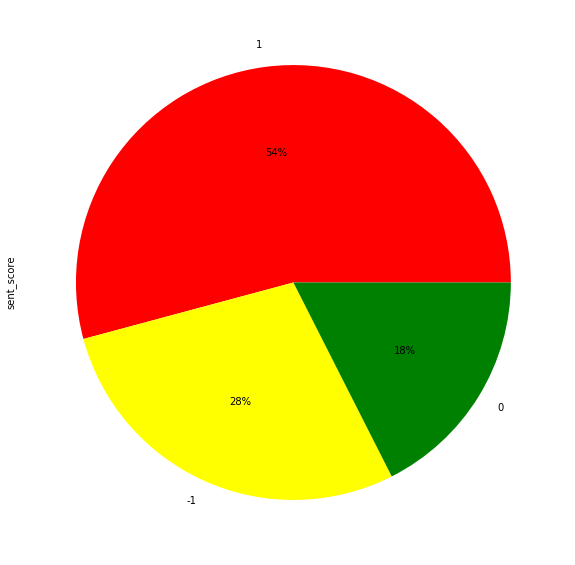

In [132]:
tweets_final.sent_score.value_counts().plot(
    kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"],figsize=(10,10))



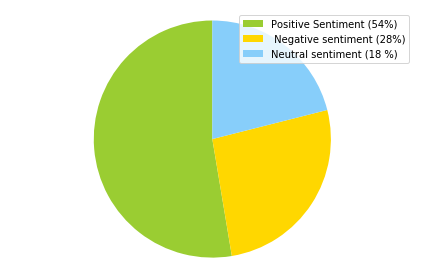

In [124]:
labels = ['Positive Sentiment (54%)',' Negative sentiment (28%)', 
'Neutral sentiment (18 %)']
sizes = [100, 50, 40]
colors = ['yellowgreen', 'gold', 'lightskyblue']
patches, texts = plt.pie(sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()